In [1]:
import os
import sys
import random

#TODO Make universal imports for all py files?

#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
sys.modules['keras'] = keras

import numpy as np

from dice import dice_coef, dice_loss
from generator import DataGen
from visualize import display_slice_from_batch

seed = 2019
random.seed = seed
#TODO make config[seed] and fix below
#np.random.seed = seed
tf.seed = seed

In [2]:
image_size = 96
patch_size = 48
percent_covered = 1e-10
train_path = "genData/train"
model_path = "sep17_largeframe_48_nonzero_standardized_local_overnight.h5"
epochs = 70
patience = 4
batch_size = 2

train_ids = next(os.walk(train_path))[1] # Returns all directories under train_path

val_data_size = 8 # Needs to be greater than batch_size

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [17]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size, patch_size=patch_size,
              percent_covered = percent_covered)
x, y = gen.__getitem__(37)
#0 - 37
print(x.shape, y.shape)

(8, 48, 48, 48, 1) (8, 48, 48, 48, 1)


(48, 48, 1)
6.848492660251944


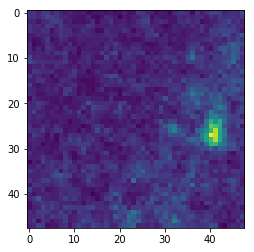

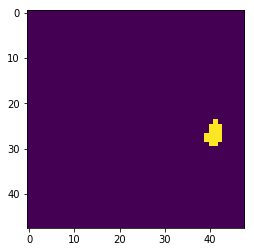

In [4]:
n=2
z=5

display_slice_from_batch(x, n, z)
print(x[n, :, :, z].shape)
print(np.amax(x[n, :, :, z]))


display_slice_from_batch(y, n, z)


In [5]:
def down_block(x, filters, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1)):
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool3D((2, 2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1)):
    us = keras.layers.Conv3DTranspose(filters*4, (2, 2, 2), (2, 2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1)):
    c = keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv3D(filters*2, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [6]:
def UNet():
    #f = [16, 32, 64, 128, 256]
    f = [32, 64, 128, 256]
    inputs = keras.layers.Input((patch_size, patch_size, patch_size, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #32 -> 16
    c2, p2 = down_block(p1, f[1]) #16 -> 8
    c3, p3 = down_block(p2, f[2]) #8 -> 4
    #c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p3, f[3])
    
    u1 = up_block(bn, c3, f[2]) #4 -> 8
    u2 = up_block(u1, c2, f[1]) #8 -> 16
    u3 = up_block(u2, c1, f[0]) #16 -> 32
    #u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv3D(1, (1, 1, 1), padding="same", activation="sigmoid")(u3)
    model = keras.models.Model(inputs, outputs)
    return model

In [7]:
model = UNet()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5), loss=dice_loss(smooth=1.), metrics=[dice_coef, 'accuracy'])#, sample_weight_mode="temporal")
model.summary()

#TODO Does valid_gen use percent_covered = 0 or nonzero?
train_gen = DataGen(train_ids, train_path, image_size=image_size, patch_size=patch_size, batch_size=batch_size, percent_covered=percent_covered)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, patch_size=patch_size, batch_size=batch_size, percent_covered=percent_covered)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 48, 1 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 48, 48, 48, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 48, 48, 48, 6 55360       conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 24, 24, 24, 6 0           conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (

In [8]:
#TODO Account for filtered patchese
train_steps = len(train_ids)*8//batch_size
valid_steps = len(valid_ids)*8//batch_size

callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
             ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1),
             ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)]

history = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs, callbacks=callbacks)

Epoch 1/70
 70/304 [=====>........................] - ETA: 16:26 - loss: -0.0127 - dice_coef: 0.0127 - acc: 0.2244

KeyboardInterrupt: 

In [14]:
import pickle
with open('trainHistoryDict_overnight', 'wb') as handle: # saving the history of the model
    pickle.dump(history.history, handle)

dict_keys(['lr', 'val_acc', 'loss', 'acc', 'dice_coef', 'val_loss', 'val_dice_coef'])


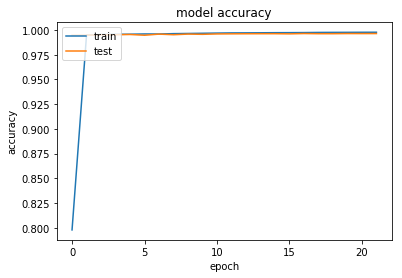

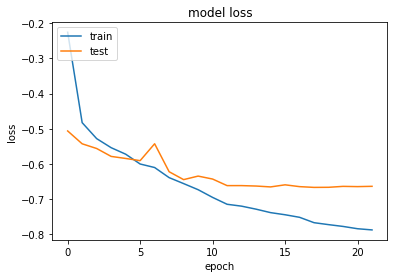

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
## Save the Weights
#model.save_weights("UNet3D1.h5")

## Dataset for prediction
test_gen = DataGen(valid_ids, train_path, image_size=image_size, patch_size=patch_size, batch_size=batch_size, percent_covered=0)
x, y = test_gen.__getitem__(0)
print(x.shape)
#result = model.predict(x)
#print(np.amax(result))
#print(np.count_nonzero(result == 1.0))
#print(result.shape)
#result = result > 0.5

#print(np.count_nonzero(result == 1.0))
#print(result.shape)
#print(np.where(result[0]==1.0)[0])
#print(result[0])

n=100
z=8

display_slice_from_batch(x,n,z)

display_slice_from_batch(y,n,z)

display_slice_from_batch(result,n,z)